In [6]:
pip install pandas numpy matplotlib seaborn scikit-learn joblib openpyxl

Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import joblib
from datetime import datetime

# Load the dataset (use pd.read_csv if CSV; adjust file name if different)
df = pd.read_excel('Online Retail.xlsx')

# Display basic info (matches your columns)
print("Dataset Shape:", df.shape)
print("\nFirst 5 Rows:")
print(df.head())
print("\nColumns:", list(df.columns))
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Shape: (541909, 8)

First 5 Rows:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  

Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

Missing Values:
InvoiceNo    

In [8]:
# 1. Handle Missing Values and Clean
df = df.dropna(subset=['CustomerID'])  # Drop rows without CustomerID
df = df[df['Quantity'] > 0]  # Remove negative quantities (returns)
df = df[df['UnitPrice'] > 0]  # Remove free/negative prices

# 2. Create RFM Features
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalSpend'] = df['Quantity'] * df['UnitPrice']  # For Monetary

# Current date for Recency (one day after last invoice)
current_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (current_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency (unique invoices)
    'TotalSpend': 'sum'  # Monetary
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Handle any remaining issues (e.g., zero Monetary)
rfm = rfm[rfm['Monetary'] > 0]

print("\nRFM Data after Preprocessing:")
print(rfm.describe())

# 3. Normalize RFM
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# Save scaler for app
joblib.dump(scaler, 'scaler.pkl')


RFM Data after Preprocessing:
           Recency    Frequency       Monetary
count  4338.000000  4338.000000    4338.000000
mean     92.536422     4.272015    2054.266460
std     100.014169     7.697998    8989.230441
min       1.000000     1.000000       3.750000
25%      18.000000     1.000000     307.415000
50%      51.000000     2.000000     674.485000
75%     142.000000     5.000000    1661.740000
max     374.000000   209.000000  280206.020000


['scaler.pkl']

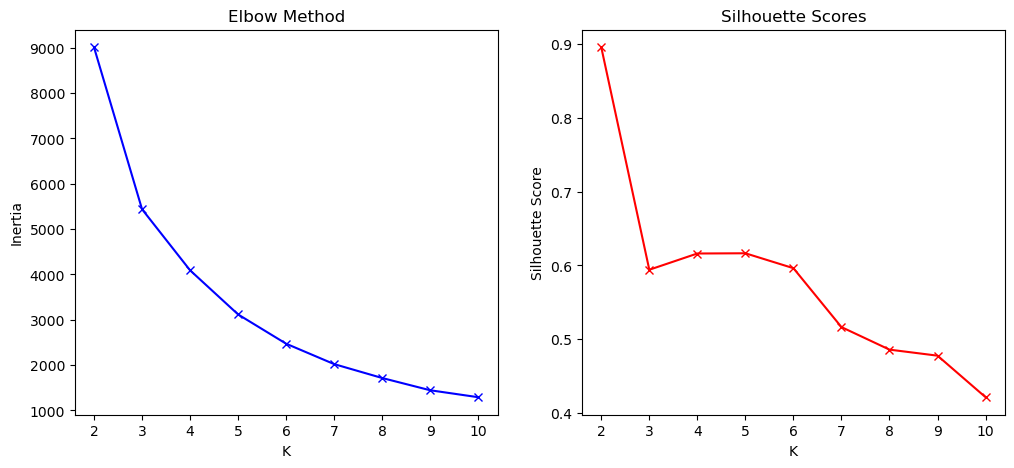

In [9]:
# Elbow Method
inertia = []
sil_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(rfm_scaled, kmeans.labels_))

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bx-')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(K, sil_scores, 'rx-')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores')

plt.show()

# Choose optimal K (e.g., elbow at 4-5; pick based on plot)
optimal_k = 4  # Adjust after seeing the plot

In [10]:
# Train K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Save model for deployment
joblib.dump(kmeans, 'kmeans_model.pkl')

print("\nCluster Summary:")
print(rfm.groupby('Cluster').mean())


Cluster Summary:
            Recency  Frequency       Monetary
Cluster                                      
0         43.702685   3.682711    1359.049284
1        248.075914   1.552015     480.617480
2          7.384615  82.538462  127338.313846
3         15.500000  22.333333   12709.090490


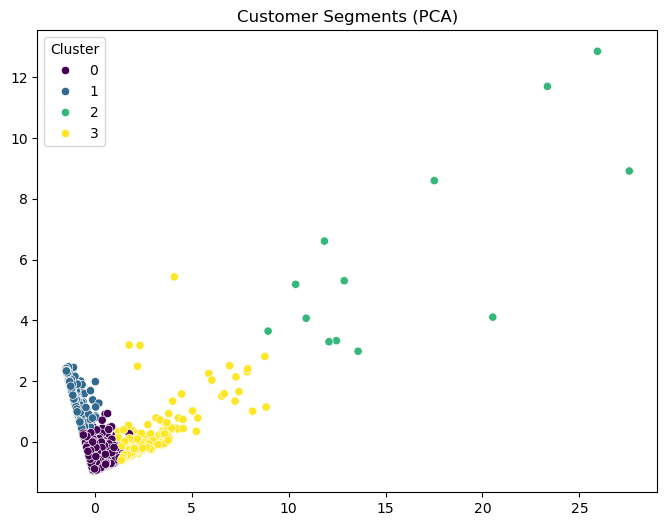

In [11]:
# PCA for 2D visualization
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=rfm_pca[:, 0], y=rfm_pca[:, 1], hue=rfm['Cluster'], palette='viridis')
plt.title('Customer Segments (PCA)')
plt.show()